In [121]:
# Setup display width, load packages, import symbols
ENV["COLUMNS"]=72
using Pkg; for p in ("Knet","Plots"); haskey(Pkg.installed(),p) || Pkg.add(p); end
using Base.Iterators: flatten
using Statistics: mean
using Random
using Knet: Knet, conv4, pool, mat, KnetArray, nll, zeroone, progress,save,load, sgd, param, param0,adam, momentum,dropout, relu, Data,gpu,minibatch

In [122]:
import Knet.load
import Knet.save
import AutoGrad

In [123]:
Pkg.status()

    Status `~/.julia/environments/v1.1/Project.toml`
  [6710c13c] AutoGrad v1.1.3
  [944b1d66] CodecZlib v0.5.2
  [5ae59095] Colors v0.9.5
  [5789e2e9] FileIO v1.0.6
  [7073ff75] IJulia v1.18.0
  [6218d12a] ImageMagick v0.7.1
  [916415d5] Images v0.17.3
  [033835bb] JLD2 v0.1.2
  [682c06a0] JSON v0.20.0
  [1902f260] Knet v1.2.1
  [ae8d54c2] Luxor v1.2.0
  [23992714] MAT v0.5.0
  [91a5bcdd] Plots v0.24.0
  [438e738f] PyCall v1.91.1
  [5e47fb64] TestImages v0.5.0


In [124]:
cd()
cd("Desktop/DeepProject/minibatches/m1")
dtst=Knet.load("dtstz.jld2","m")
cd()
cd("/media/mvgl/DATAONE/Tugce")
dtrn=Knet.load("dtstz8t.jld2","m")

Data{Tuple{KnetArray{Float32,4},KnetArray{Float32,4}}}([0.788235 0.415686 … 0.796078 0.537255; 0.788235 0.415686 … 0.8 0.545098; … ; 0.290196 0.231373 … 0.439216 0.556863; 0.294118 0.231373 … 0.45098 0.556863], Float32[0.0 0.0 … 0.0 0.0; 2.66899 15.1749 … 5.47408 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], 30, 1260, false, 1231, 1:1260, false, (224, 224, 3, 30), (7, 7, 512, 1260), KnetArray{Float32,N} where N, KnetArray{Float32,N} where N)

In [125]:
(x,y) = first(dtrn)
println.(summary.((x,y)));

224×224×3×30 KnetArray{Float32,4}
7×7×512×30 KnetArray{Float32,4}


In [126]:
(x1,y1) = first(dtst)
println.(summary.((x1,y1)));

224×224×3×32 KnetArray{Float32,4}
7×7×512×32 KnetArray{Float32,4}


In [127]:
function trainresults(file,model; o...)
   # if (print("Train from scratch? "); readline()[1]=='y')
        takeevery(n,itr) = (x for (i,x) in enumerate(itr) if i % n == 1)
        r = ((model(dtrn), model(dtst))
           for x in takeevery(length(dtrn), progress(adam(model,repeat(dtrn,200);lr=1e-03))))
        print("done")
          # print(size(r,1))      
        r = reshape(collect(Float32,flatten(r)),(2,:))
               
          print("done")
       # Knet.gc() # To save gpu memory
    #else
       # isfile(file) || download("http://people.csail.mit.edu/deniz/models/tutorial/$file",file)
       # r = Knet.load(file,"results")
   # end
   # println(minimum(r,dims=2))
   return r
end

trainresults (generic function with 1 method)

In [128]:
# Let's define a chain of layers
struct Chain
    layers
    Chain(layers...) = new(layers)
end
(c::Chain)(x) = (for l in c.layers; x = l(x); end; x)
(c::Chain)(x,y) = mean(abs2.(c(x)-y))
(c::Chain)(d::Data) = mean(c(x,y) for (x,y) in d)

In [129]:
# Define a convolutional layer:
struct Conv; w; b; f; p; end
(c::Conv)(x) = c.f.(pool(conv4(c.w, dropout(x,c.p)) .+ c.b))
Conv(w1::Int,w2::Int,cx::Int,cy::Int,f=relu;pdrop=0) = Conv(param(w1,w2,cx,cy), param0(1,1,cy,1), f, pdrop)

Conv

In [130]:
# Define a convolutional layer:
struct Conv0; w; b; f; p; end
(c::Conv0)(x) = c.f.(pool(conv4(c.w, dropout(x,c.p);padding=1).+ c.b;window=3,stride=2))
Conv0(w1::Int,w2::Int,cx::Int,cy::Int,f=relu;pdrop=0) = Conv0(param(w1,w2,cx,cy), param0(1,1,cy,1), f, pdrop)

Conv0

In [131]:
# Define a convolutional layer:
struct Conv01; w; b; f; p; end
(c::Conv01)(x) = c.f.(pool(conv4(c.w, dropout(x,c.p);padding=1).+ c.b;window=3,stride=2))
Conv01(w ,b,f=relu;pdrop=0) = Conv01(w ,b, f, pdrop)

Conv01

In [132]:
# Define a convolutional layer:
struct Conv1; w; b; f; p; end
(c::Conv1)(x) = c.f.(pool(conv4(c.w, dropout(x,c.p);padding=1).+ c.b;window=3,padding=1,stride=2))
Conv1(w1::Int,w2::Int,cx::Int,cy::Int,f=relu;pdrop=0) = Conv1(param(w1,w2,cx,cy), param0(1,1,cy,1), f, pdrop)

Conv1

In [133]:
# Define a convolutional layer:
struct Conv11; w; b; f; p; end
(c::Conv11)(x) = c.f.(pool(conv4(c.w, dropout(x,c.p);padding=1).+ c.b;window=3,padding=1,stride=2))
Conv11(w ,b,f=relu;pdrop=0) = Conv11(w ,b, f, pdrop)


Conv11

In [134]:
# Redefine dense layer (See mlp.ipynb):
struct Dense; w; b; f; p; end
(d::Dense)(x) = d.f.(d.w * mat(dropout(x,d.p)) .+ d.b) # mat reshapes 4-D tensor to 2-D matrix so we can use matmul
Dense(i::Int,o::Int,f=relu;pdrop=0) = Dense(param(o,i), param0(o), f, pdrop)

Dense

In [135]:
lenet1 =   Chain(Conv0(3,3,3,64),
                 Conv0(3,3,64,128),
                 Conv0(3,3,128,256),
                Conv0(3,3,256,256),
                Conv1(3,3,256,512))
summary.(l.w for l in lenet1.layers)

5-element Array{String,1}:
 "3×3×3×64 AutoGrad.Param{KnetArray{Float32,4}}"   
 "3×3×64×128 AutoGrad.Param{KnetArray{Float32,4}}" 
 "3×3×128×256 AutoGrad.Param{KnetArray{Float32,4}}"
 "3×3×256×256 AutoGrad.Param{KnetArray{Float32,4}}"
 "3×3×256×512 AutoGrad.Param{KnetArray{Float32,4}}"

In [136]:
cnn= trainresults("cnn2.jld2", lenet1);

1.25e+02  100.00%┣█████████████████████┫ 8400/8400 [15:53/15:53, 8.81i/s]
done

In [137]:
using Plots; default(fmt=:png,ls=:auto)

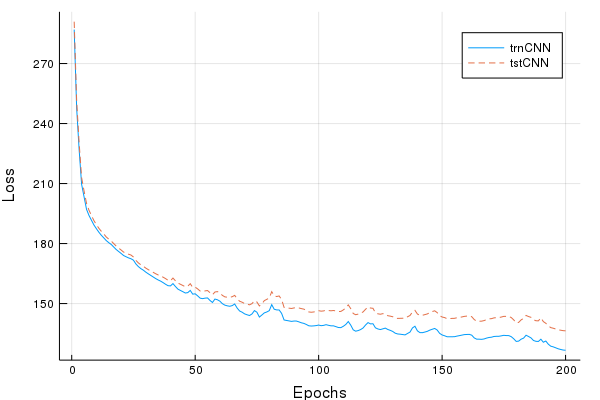

In [138]:
plot([cnn[1,:], cnn[2,:]],
     labels=[:trnCNN :tstCNN],xlabel="Epochs",ylabel="Loss")

In [139]:
cd()
cd("/media/mvgl/DATAONE/Tugce")
Knet.save("lenet1loss8t.jld2","b",lenet1)

In [140]:
cd()
cd(readdir, "/media/mvgl/DATAONE/Tugce")

104-element Array{String,1}:
 "cnn2.jld2"         
 "conf"              
 "confnn"            
 "confy1t.jld2"      
 "confyp1t.jld2"     
 "dtest1.jld2"       
 "dtest1n.jld2"      
 "dtest1nn.jld2"     
 "dtest1t.jld2"      
 "dtest2.jld2"       
 "dtest2nn.jld2"     
 "dtest2t.jld2"      
 "dtest3.jld2"       
 ⋮                   
 "lenet1loss5.jld2"  
 "lenet1loss5nn.jld2"
 "lenet1loss5t.jld2" 
 "lenet1loss6.jld2"  
 "lenet1loss6nn.jld2"
 "lenet1loss6t.jld2" 
 "lenet1loss7.jld2"  
 "lenet1loss7nn.jld2"
 "lenet1loss7t.jld2" 
 "lenet1loss8.jld2"  
 "lenet1loss8nn.jld2"
 "lenet1loss8t.jld2" 